In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import matplotlib.gridspec as gridspec
from copy import copy
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.stats import spearmanr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [2]:
# useful stuff

district_labels = [ 'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal',
'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais',
'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte',  
'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins' ]

district_names = ['acre', 'alagoas', 'amapas', 'amazonas', 'bahia', 'ceara', 'distrito_federal', 'espirito_santo',
           'goias', 'maranhao', 'mato_grosso', 'mato_grosso_do_sul', 'minas_gerais', 'para', 'paraiba', 'parana',
           'pernambuco', 'piaui', 'rio_de_janeiro', 'rio_grande_do_norte', 'rio_grande_do_sul', 'rondonia',
           'roraima', 'santa_catarina', 'sao_paulo', 'sergipe', 'tocantins']

districts_by_region = { 'North': ['Rondônia', 'Acre', 'Amazonas', 'Roraima', 'Pará', 'Amapá', 'Tocantins'], 
  'North-East': [ 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco',
                  'Alagoas', 'Sergipe', 'Bahia'], 
  'South-East': ['Minas Gerais', 'Espírito Santo', 'Rio de Janeiro', 'São Paulo'], 
  'South': ['Paraná', 'Santa Catarina', 'Rio Grande do Sul'], 
  'Center-West' : ['Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Distrito Federal'] }

district_codes = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 
                  'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']


label2name = { district_labels[i] : name for i, name in enumerate( district_names ) }
label2code = { district_labels[i] : code for i, code in enumerate( district_codes ) }
code2name  = { district_codes[i] : name for i, name in enumerate( district_names ) }
name2code  = { name : code for code, name in code2name.items() }


code2region = {}
codes_by_region = {}
for region, districts in districts_by_region.items():
    codes_by_region[region] = []
    for label in districts:
        code = label2code[label]
        code2region[code] = region
        codes_by_region[region].append( code )
        

base_path = '../data'

years = list( range( 2008, 2020 ) )

years_str = [ str( el ) for el in years ]

age_cols_h = ['<1', '1-4', '5-9', '10-14', '15-19', '20-24',
       '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64',
       '65-69', '70-74', '75-79', '>80']
age_cols_c = ['<1', '1-4', '5-9', '10-14', '15-19', '20-39', '40-59',
       '60-64', '65-69', '70-79', '>80']

agebins_h = [ 0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 101]
agebins_c = [ 0, 1, 5, 10, 15, 20, 40, 60, 65, 70, 80, 101 ]

# Main figure: weekly DENV and ZIKV incidence in Feira de Santana

(-0.5, 572.0)

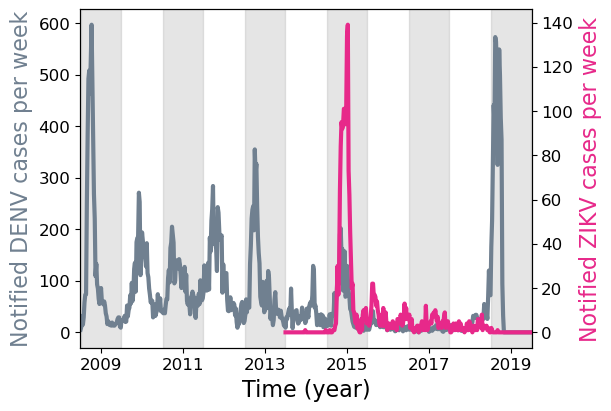

In [4]:
fig, ax = plt.subplots( figsize = ( 6, 4 ), ncols = 1, constrained_layout = True )

ax2 = ax.twinx()

lw = 3
colorD = 'slategray'
colorZ = '#e7298a'


#=== A) plot laboratory confirmed cases over time
file = '../data/3vFSA/dadosdenguefeiradesantana2009a2019/1) FSA-Dengue Casos notificados por semana epidemiológica 2009 a 2019.xlsx'
df = pd.read_excel( file, skiprows=2, skipfooter=1 )

df['Sem.Epid Notific'] = df['Sem.Epid Notific'].replace( {'Semana 53': 'Semana 52'})
df = df.loc[df['Sem.Epid Notific'] != 'Em Branco']
df = df.groupby('Sem.Epid Notific', as_index = False )[[str(year) for year in range(2009,2020)]].sum()
incd = np.concatenate( [df[str(year)].values for year in range(2009,2020)] )

nyears = int( len( incd ) / 52 )
for i in range(0,nyears,2):
    ax.axvspan( i * 52, ( i + 1 ) * 52 - 1, color = 'grey', alpha = 0.2, zorder = 0 )
ax.plot(incd, lw = 3, zorder = 1, label = 'DENV', color = colorD )

# plot zika
file = '../data/3vFSA/dadoszikafsa2014a2019/1) FSA-Zika Casos notificados de zika ´por semana epidemiológica 2014 a 2019..xlsx'

df = pd.read_excel( file, skiprows = 2, skipfooter=1 )
df['Sem.Epid.Sintomas'] = df['Sem.Epid.Sintomas'].replace( {'Semana 53': 'Semana 52'})
df = df.loc[df['Sem.Epid.Sintomas'] != 'Em Branco']
df = df.groupby('Sem.Epid.Sintomas', as_index = False )[['2014', '2015', '2016', '2017', '2018', '2019']].sum()
incz = np.concatenate( [df[str(year)].values for year in range(2014,2020)] )
ax2.plot( [52 * 5 + i for i in range( 52 * 6 ) ], incz, lw = 3, label = 'ZIKV', color = colorZ,
        zorder = -1)



ax.set_xticks( [ 26 + 52 * y for y in range(0, nyears, 2) ])
ax.set_xticklabels( [ y for y in range(2009, 2020, 2) ])

ax.tick_params( axis = 'both', which = 'major', labelsize = 12 )
ax2.tick_params( axis = 'both', which = 'major', labelsize = 12 )

ax.set_xlabel( 'Time (year)', fontsize = 16 )
ax.set_ylabel( 'Notified DENV cases per week', fontsize = 16 )
ax2.set_ylabel( 'Notified ZIKV cases per week', fontsize = 16 )

ax.yaxis.label.set_color( colorD )
ax2.yaxis.label.set_color( colorZ )  


ax.set_xlim( -0.5, 52 * 11 )

# Main figure: cumulative distributions of case and hospitalisation counts before and after ZIKV in Feira de Santana, Salvador and Bahia

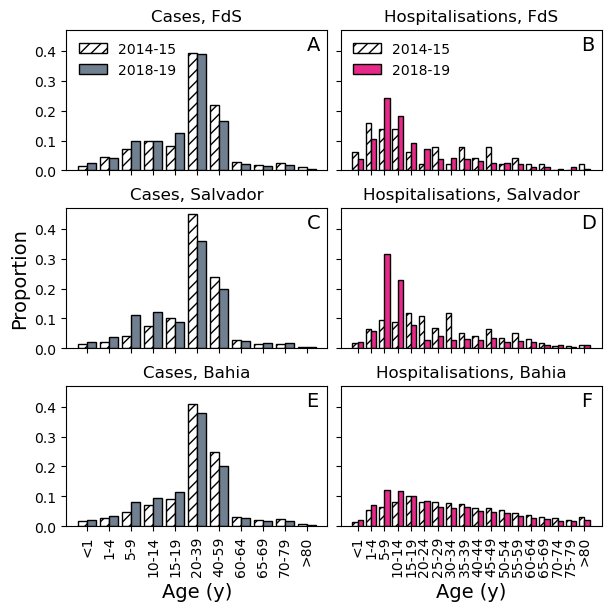

In [9]:
ig, ax = plt.subplots( figsize = ( 6, 6 ), ncols = 2, nrows = 3,
                       constrained_layout = True, sharey = True, sharex = 'col')

width = 0.4
years_pre = [2014, 2015]
years_post = [2018, 2019]

color_hosp = '#e7298a'
color_cases = 'slategray'

paths_cases = {
    'FdS': '../data/c_fds_post2013_sinan_clean.csv',
    'Salvador': '../data/c_salvador_post2013_sinan_clean.csv',
    'Bahia': '../data/c_bahia_post2013_sinan_clean.csv'
}

paths_hosp = {
    'FdS': '../data/h_fds_post2007_sus_clean.csv',
    'Salvador': '../data/h_salvador_post2007_sus_clean.csv',
    'Bahia': '../data/h_bahia_post2007_sus_clean.csv'
}

counter = 0
for i, locname in enumerate( [ 'FdS', 'Salvador', 'Bahia' ] ):
    

    
    #== plot cases
    
    axi = ax[i,0]
    
    df = pd.read_csv( paths_cases[locname] )
    histo_pre = df.loc[df['year'].isin( years_pre ), age_cols_c ].sum( axis = 0 )
    histo_post = df.loc[df['year'].isin( years_post ), age_cols_c ].sum( axis = 0 )
    
    xx1 = np.arange( len( age_cols_c ) ) - 0.5 * width
    xx2 = np.arange( len( age_cols_c ) ) + 0.5 * width
    
    axi.bar( xx1, histo_pre / histo_pre.sum(), width = width, hatch = '///',
              edgecolor = 'black', facecolor = 'none', label = '2014-15' )
    axi.bar( xx2, histo_post/ histo_post.sum(), width = width,
              edgecolor = 'black', facecolor = color_cases, label = '2018-19' )
    
    #== plot hosp
    
    axi = ax[i,1]
    
    df = pd.read_csv( paths_hosp[locname] )
    histo_pre = df.loc[df['year'].isin( years_pre ), age_cols_h ].sum( axis = 0 )
    histo_post = df.loc[df['year'].isin( years_post ), age_cols_h ].sum( axis = 0 )
    
    xx1 = np.arange( len( age_cols_h ) ) - 0.5 * width
    xx2 = np.arange( len( age_cols_h ) ) + 0.5 * width
    
    axi.bar( xx1, histo_pre / histo_pre.sum(), width = width, hatch = '///',
              edgecolor = 'black', facecolor = 'none', label = '2014-15' )
    axi.bar( xx2, histo_post/ histo_post.sum(), width = width,
              edgecolor = 'black', facecolor = color_hosp, label = '2018-19' )
    
ax[1,0].set_ylabel( 'Proportion', fontsize = 14 ) 


ax[-1,0].set_xticks( np.arange( len( age_cols_c ) ) )
ax[-1,1].set_xticks( np.arange( len( age_cols_h ) ) )
ax[-1,0].set_xticklabels( age_cols_c )
ax[-1,1].set_xticklabels( age_cols_h )



for axi in ax[-1,:]:
    axi.set_xlabel( 'Age (y)', fontsize = 14 )
    axi.tick_params( which = 'major', axis = 'x', rotation = 90 )
    
letters = ['A','B','C','D','E','F']

ax[0,0].legend( framealpha = False, fontsize = 10, loc = 'upper left' )
ax[0,1].legend( framealpha = False, fontsize = 10, loc = 'upper left' )

ax[0,0].set_title( 'Cases, FdS', fontsize = 12 )
ax[0,1].set_title( 'Hospitalisations, FdS', fontsize = 12 )
ax[1,0].set_title( 'Cases, Salvador', fontsize = 12 )
ax[1,1].set_title( 'Hospitalisations, Salvador', fontsize = 12 )
ax[2,0].set_title( 'Cases, Bahia', fontsize = 12 )
ax[2,1].set_title( 'Hospitalisations, Bahia', fontsize = 12 )

for iax, axi in enumerate( ax.flatten() ):
    axi.tick_params( which = 'major', axis = 'x', labelsize = 10)
    axi.tick_params( axis = 'x', rotation = 90 )
    axi.text( 0.92, 0.85, letters[iax], fontsize = 14, transform = axi.transAxes )

## Test whether post-ZIKV incidence is 'younger' than before ZIKV

Uses a one-tail, two-sample permutation test: the null-hypothesis of this test is that samples 's1' and 's2', expressed as lists of case counts, come from the same distribution

FdS c -3.0981488529478476 0.0
FdS h -3.014677943249371 0.13667
Salvador c -3.8495200198928643 0.0
Salvador h -9.093174267592872 0.0
Bahia c -2.9966698986137565 0.0
Bahia h -4.584558928218886 0.0


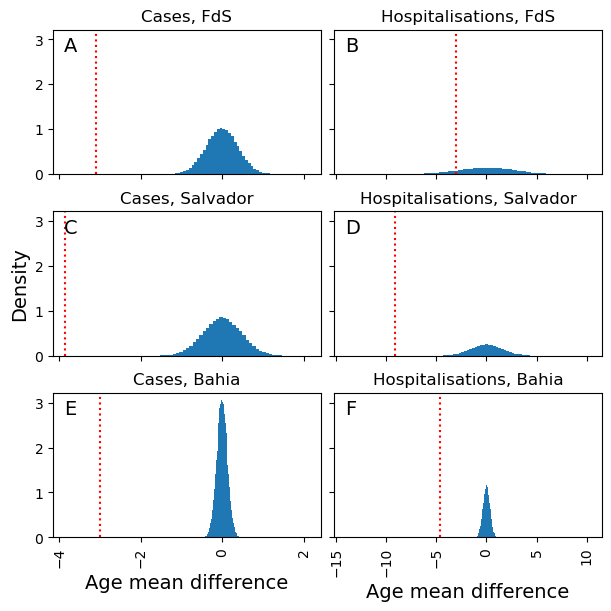

In [79]:
def permutation_test_1s_negative( s1, s2, midpoints, f, Nsim ):
    
    '''
    's1', 's2' are two lists of counts, the age distributions to be compared
    'midpoints' are integer/float values associated with entries of histograms 's1','s2'
    'f' is a function that computes a test statistic from 's1', 's2' and 'midpoints'
    The permutation procedure is applied 'Nsim' times
    Returns a pair consisting of f(s1,s2,midpoints), the test statistic of the observed
    sample, and a list of 'Nsim' test statistics obtained from permuted samples
    '''
    
    midpoints = np.atleast_1d( midpoints )
    s1, s2 = np.atleast_1d( s1 ), np.atleast_1d( s2 )
    s = s1 + s2
    n1, n2, n = sum( s1 ), sum( s2 ), sum( s )
    s = s / n
    res = []
    for sim in range( Nsim ):
        
        s1_tmp = np.random.multinomial( n1, s )
        s2_tmp = np.random.multinomial( n2, s )
        
        tmp = f( s1_tmp, s2_tmp, midpoints )
        
        res.append( tmp )
        
    return f( s1, s2, midpoints ), np.array( res )

years_pre = [2014, 2015]
years_post = [2018, 2019]


df = pd.read_csv( paths_cases['Bahia'] )
histo_pre = df.loc[df['year'].isin( years_pre ), age_cols_c ].sum( axis = 0 )
histo_post = df.loc[df['year'].isin( years_post ), age_cols_c ].sum( axis = 0 )

# remove last bin
histo_pre = histo_pre[:-1].values
histo_post = histo_post[:-1].values
agebins_tmp = agebins_c[:-2] + np.diff( agebins_c )[:-1] * 0.5

def diff_means( s1, s2, midbins ):
    '''
    Gets the difference between the means of two histograms 's2' and 's1'
    '''
    m1 = np.dot( s1, midbins ) / sum( s1 )
    m2 = np.dot( s2, midbins ) / sum( s2 )    
    
    return m2 - m1

#diff_means( histo_pre, histo_post, agebins_tmp )

Nsim = 10000
diff_obs, diff_perm = permutation_test_1s_negative( histo_pre, histo_post, agebins_tmp, 
                                                   diff_means, Nsim )


fig, ax = plt.subplots( figsize = ( 6, 6 ), ncols = 2, nrows = 3,
                       constrained_layout = True, sharey = True, sharex = 'col')

lw = 2
years_pre = [2014, 2015]
years_post = [2018, 2019]

color_hosp = '#e7298a'
color_cases = 'slategray'

paths_cases = {
    'FdS': '../data/c_fds_post2013_sinan_clean.csv',
    'Salvador': '../data/c_salvador_post2013_sinan_clean.csv',
    'Bahia': '../data/c_bahia_post2013_sinan_clean.csv'
}

paths_hosp = {
    'FdS': '../data/h_fds_post2007_sus_clean.csv',
    'Salvador': '../data/h_salvador_post2007_sus_clean.csv',
    'Bahia': '../data/h_bahia_post2007_sus_clean.csv'
}

def diff_means( s1, s2, midbins ):
    
    m1 = np.dot( s1, midbins ) / sum( s1 )
    m2 = np.dot( s2, midbins ) / sum( s2 )    
    
    return m2 - m1

Nsim = 100000

counter = 0
for i, locname in enumerate( [ 'FdS', 'Salvador', 'Bahia' ] ):
    
    #== plot cases
    
    axi = ax[i,0]
    
    df = pd.read_csv( paths_cases[locname] )
    histo_pre = df.loc[df['year'].isin( years_pre ), age_cols_c ].sum( axis = 0 )
    histo_post = df.loc[df['year'].isin( years_post ), age_cols_c ].sum( axis = 0 )
    
    # remove last bin
    histo_pre = histo_pre[:-1].values
    histo_post = histo_post[:-1].values
    agebins_tmp = agebins_c[:-2] + np.diff( agebins_c )[:-1] * 0.5
    
    diff_obs, diff_perm = permutation_test_1s_negative( histo_pre, histo_post, agebins_tmp, 
                                                   diff_means, Nsim )
    
    print( locname, 'c', diff_obs, sum( diff_perm < diff_obs ) / Nsim  )
    
    axi.hist( diff_perm, density = True, bins = 50 )
    axi.axvline( x = diff_obs, ls = ':', c = 'red')

    #== plot hosp
    
    axi = ax[i,1]
    
    df = pd.read_csv( paths_hosp[locname] )
    histo_pre = df.loc[df['year'].isin( years_pre ), age_cols_h ].sum( axis = 0 )
    histo_post = df.loc[df['year'].isin( years_post ), age_cols_h ].sum( axis = 0 )
    
    
    # remove last bin
    histo_pre = histo_pre[:-1].values
    histo_post = histo_post[:-1].values
    agebins_tmp = agebins_h[:-2] + np.diff( agebins_h )[:-1] * 0.5
    
    diff_obs, diff_perm = permutation_test_1s_negative( histo_pre, histo_post, agebins_tmp, 
                                                   diff_means, Nsim )
    
    print( locname, 'h', diff_obs, sum( diff_perm < diff_obs ) / Nsim  )
    axi.hist( diff_perm, density = True, bins = 50 )
    axi.axvline( x = diff_obs, ls = ':', c = 'red')
    
ax[1,0].set_ylabel( 'Density', fontsize = 14 ) 
for axi in ax[-1,:]:
    axi.set_xlabel( 'Age mean difference', fontsize = 14 )
    axi.tick_params( which = 'major', axis = 'x', rotation = 90 )
    
letters = ['A','B','C','D','E','F']

#ax[0,0].legend( framealpha = False, fontsize = 10, loc = 'lower right' )

ax[0,0].set_title( 'Cases, FdS', fontsize = 12 )
ax[0,1].set_title( 'Hospitalisations, FdS', fontsize = 12 )
ax[1,0].set_title( 'Cases, Salvador', fontsize = 12 )
ax[1,1].set_title( 'Hospitalisations, Salvador', fontsize = 12 )
ax[2,0].set_title( 'Cases, Bahia', fontsize = 12 )
ax[2,1].set_title( 'Hospitalisations, Bahia', fontsize = 12 )

for iax, axi in enumerate( ax.flatten() ):
    axi.tick_params( which = 'major', axis = 'x', labelsize = 10)
    axi.tick_params( axis = 'x', rotation = 90 )
    axi.text( 0.04, 0.85, letters[iax], fontsize = 14, transform = axi.transAxes )

## Age shift calculation code

In [3]:
def estimate_mean_age_bootstrap( distr, agebins, nreps ):
    
    '''
    Creates a list with 'nreps' bootstrap estimates of mean age
    starting from counts 'distr' aggregated over some bins ('agebins')
    
    First creates 'nreps' bootstrap incidence samples with the same total
    case count and then calculates mean age for each sample
    '''
    
    na = len( distr ) # number of bins
    n = sum( distr )  # total cases

    aa = np.arange( agebins[-1] )
    
    mean_age_samples = []
    
    for rep in range( nreps ):
        
        # sample new incidence per bin with replacement
        inc_bootstrap = np.bincount( np.random.choice( a = range( na ), size = n, p = distr / n, replace = True ), minlength=na )            

        inc_bootstrap2 = np.zeros( len( aa ) )
        # within each bin, sample ages with replacement
        for i, nc in enumerate( inc_bootstrap ):
            if nc > 0:
                a, b = agebins[i], agebins[i+1]
                ages = np.arange( a, b )
                inc_bootstrap2 += np.bincount( np.random.choice( a = ages, size = nc, replace = True ), minlength=len(aa) )            

        mean_age = np.dot( aa, inc_bootstrap2 ) / inc_bootstrap2.sum()
        mean_age_samples.append( mean_age )
        
    return np.array( mean_age_samples )

nreps = 1000 # number of repetitions

## ZIKV attack rate

The following dictionary contains estimates of ZIKV attack rate by state

In [8]:
# zikv attack rate
zikv_ar_perkins = {
    'AC': 301 / 1768.,
    'AL': 1301 / 1768.,
    'AP': 602 / 1768.,
    'AM': 478 / 1768.,
    'BA': 1039 / 1768.,
    'CE': 640 / 1768.,
    'DF': 298 / 1768.,
    'ES': 749 / 1768.,
    'GO': 498 / 1768.,
    'MA': 739 / 1768.,
    'MT': 919 / 1768.,
    'MS': 242 / 1768.,
    'MG': 205 / 1768.,
    'PA': 91 / 1768.,
    'PB': 1184 / 1768.,
    'PR': 30 / 1768.,
    'PE': 1117 / 1768.,
    'PI': 822 / 1768.,
    'RJ': 494 / 1768.,
    'RN': 1013 / 1768.,
    'RS': 98 / 1768.,
    'RO': 460 / 1768.,
    'RR': 808 / 1768.,
    'SC': 86 / 1768.,
    'SP': 148 / 1768.,
    'SE': 1354 / 1768.,
    'TO': 478 / 1768.
}

# Process data for main figure

Calculates mean age over different time windows, the age difference before and after ZIKV and the corresponding uncertainty.

The preprocessing step is applied to case and hospitalisation data separately.

In [7]:
#=== Analyse hospitalisation data

names            = []
place_type       = []
mean_age_pre     = []
mean_age_post    = []
mean_age_diff    = []
std_age_diff     = []
perc_lo_age_diff = []
perc_hi_age_diff = []

# analyse states

df0 = pd.read_csv( '../data/h_age_uf_0020.csv' )

for name in district_names:
    
    print( name )
    
    df = df0.loc[df0['code'] == name2code[name]]
    tmp_inc_h_pre  = df.loc[df['year'].isin([ 2013, 2014, 2015]), age_cols_h].sum( axis = 0 )
    tmp_inc_h_post = df.loc[df['year'].isin([ 2018, 2019]), age_cols_h].sum( axis = 0 )
    
    # get histogram (ignore last bin)
    histo_pre  = tmp_inc_h_pre[age_cols_h].values[:-1]
    histo_post = tmp_inc_h_post[age_cols_h].values[:-1]
    
    ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_h[:-1], nreps )
    ages_post = estimate_mean_age_bootstrap( histo_post, agebins_h[:-1], nreps )
    ages_diff = ages_post / ages_pre - 1
    
    names.append( name )
    place_type.append( 'state' )
    mean_age_pre.append( ages_pre.mean() )
    mean_age_post.append( ages_post.mean() )
    mean_age_diff.append( ages_diff.mean() )
    std_age_diff.append( ages_diff.std() )
    perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
    perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )
    

# hosp for salvador
print('salvador')

path_salv_h = '../data/h_salvador_post2007_sus_clean.csv'
df = pd.read_csv( path_salv_h )
histo_pre  = df.loc[df['year'].isin( range(2013, 2016) ), age_cols_h ].sum( axis = 0 ).values[:-1]
histo_post = df.loc[df['year'].isin( range(2018, 2020) ), age_cols_h ].sum( axis = 0 ).values[:-1]

ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_h[:-1], nreps )
ages_post = estimate_mean_age_bootstrap( histo_post, agebins_h[:-1], nreps )
ages_diff = ages_post / ages_pre - 1

names.append( 'salvador' )
place_type.append( 'city' )
mean_age_pre.append( ages_pre.mean() )
mean_age_post.append( ages_post.mean() )
mean_age_diff.append( ages_diff.mean() )
std_age_diff.append( ages_diff.std() )
perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )

# hosp for fds
print('feira_de_santana')

path_fds_h = '../data/h_fds_post2007_sus_clean.csv' 
df = pd.read_csv( path_fds_h )
histo_pre  = df.loc[df['year'].isin( range(2013, 2016) ), age_cols_h ].sum( axis = 0 ).values[:-1]
histo_post = df.loc[df['year'].isin( range(2018, 2020) ), age_cols_h ].sum( axis = 0 ).values[:-1]

ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_h[:-1], nreps )
ages_post = estimate_mean_age_bootstrap( histo_post, agebins_h[:-1], nreps )
ages_diff = ages_post / ages_pre - 1

names.append( 'feira_de_santana' )
place_type.append( 'city' )
mean_age_pre.append( ages_pre.mean() )
mean_age_post.append( ages_post.mean() )
mean_age_diff.append( ages_diff.mean() )
std_age_diff.append( ages_diff.std() )
perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )

acre
alagoas
amapas
amazonas
bahia
ceara
distrito_federal
espirito_santo
goias
maranhao
mato_grosso
mato_grosso_do_sul
minas_gerais
para
paraiba
parana
pernambuco
piaui
rio_de_janeiro
rio_grande_do_norte
rio_grande_do_sul
rondonia
roraima
santa_catarina
sao_paulo
sergipe
tocantins
salvador
feira_de_santana


In [9]:
# save hosp data into dataframe

df_hosp = { 'name': names, 'place_type': place_type, 'mean_age_pre': mean_age_pre,
          'mean_age_post': mean_age_post, 'mean_age_diff': mean_age_diff, 
          'std_age_diff': std_age_diff,
          'perc_lo_age_diff': perc_lo_age_diff, 'perc_hi_age_diff': perc_hi_age_diff }

df_hosp = pd.DataFrame( df_hosp )
df_hosp.to_csv( 'h_age_diff_stats_mainfigure.csv', index=False )

In [52]:
#=== Analyse reported case data

names            = []
place_type       = []
mean_age_pre     = []
mean_age_post    = []
mean_age_diff    = []
std_age_diff     = []
perc_lo_age_diff = []
perc_hi_age_diff = []

# analyse states

df0 = pd.read_csv( '../data/c_age_uf_0120.csv' )

for name in district_names:
    
    print( name )
    
    df = df0.loc[df0['code'] == name2code[name]]
    tmp_inc_c_pre  = df.loc[df['year'].isin([ 2013, 2014, 2015]), age_cols_c].sum( axis = 0 )
    tmp_inc_c_post = df.loc[df['year'].isin([ 2018, 2019]), age_cols_c].sum( axis = 0 )
    
    # get histogram (ignore last bin)
    histo_pre  = tmp_inc_c_pre[age_cols_c].values[:-1]
    histo_post = tmp_inc_c_post[age_cols_c].values[:-1]
    
    ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_c[:-1], nreps )
    ages_post = estimate_mean_age_bootstrap( histo_post, agebins_c[:-1], nreps )
    ages_diff = ages_post / ages_pre - 1
    
    names.append( name )
    place_type.append( 'state' )
    mean_age_pre.append( ages_pre.mean() )
    mean_age_post.append( ages_post.mean() )
    mean_age_diff.append( ages_diff.mean() )
    std_age_diff.append( ages_diff.std() )
    perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
    perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )
    

# cases for salvador
print('salvador')

path_salv_c = '../data/c_salvador_post2013_sinan_clean.csv'
df = pd.read_csv( path_salv_c )
histo_pre  = df.loc[df['year'].isin( range(2013, 2016) ), age_cols_c ].sum( axis = 0 ).values[:-1]
histo_post = df.loc[df['year'].isin( range(2018, 2020) ), age_cols_c ].sum( axis = 0 ).values[:-1]

ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_c[:-1], nreps )
ages_post = estimate_mean_age_bootstrap( histo_post, agebins_c[:-1], nreps )
ages_diff = ages_post / ages_pre - 1

names.append( 'salvador' )
place_type.append( 'city' )
mean_age_pre.append( ages_pre.mean() )
mean_age_post.append( ages_post.mean() )
mean_age_diff.append( ages_diff.mean() )
std_age_diff.append( ages_diff.std() )
perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )

# cases for fds
print('feira_de_santana')

path_fds_c = '../data/c_fds_post2013_sinan_clean.csv' 
df = pd.read_csv( path_fds_c )
histo_pre  = df.loc[df['year'].isin( range(2013, 2016) ), age_cols_c ].sum( axis = 0 ).values[:-1]
histo_post = df.loc[df['year'].isin( range(2018, 2020) ), age_cols_c ].sum( axis = 0 ).values[:-1]

ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_c[:-1], nreps )
ages_post = estimate_mean_age_bootstrap( histo_post, agebins_c[:-1], nreps )
ages_diff = ages_post / ages_pre - 1

names.append( 'feira_de_santana' )
place_type.append( 'city' )
mean_age_pre.append( ages_pre.mean() )
mean_age_post.append( ages_post.mean() )
mean_age_diff.append( ages_diff.mean() )
std_age_diff.append( ages_diff.std() )
perc_lo_age_diff.append( np.percentile( a = ages_diff, q = 2.5 ) )
perc_hi_age_diff.append( np.percentile( a = ages_diff, q = 97.5 ) )

acre
alagoas
amapas
amazonas
bahia
ceara
distrito_federal
espirito_santo
goias
maranhao
mato_grosso
mato_grosso_do_sul
minas_gerais
para
paraiba
parana
pernambuco
piaui
rio_de_janeiro
rio_grande_do_norte
rio_grande_do_sul
rondonia
roraima
santa_catarina
sao_paulo
sergipe
tocantins
salvador
feira_de_santana


In [53]:
# save data into dataframe

df_cases = { 'name': names, 'place_type': place_type, 'mean_age_pre': mean_age_pre,
          'mean_age_post': mean_age_post, 'mean_age_diff': mean_age_diff, 'std_age_diff': std_age_diff,
          'perc_lo_age_diff': perc_lo_age_diff, 'perc_hi_age_diff': perc_hi_age_diff }

df_cases = pd.DataFrame( df_cases )
df_cases.to_csv( 'c_age_diff_stats_mainfigure.csv', index=False )

## Compare age shift using various periods for pre-ZIKV

Calculates the age shift across the pre- and post-ZIKV eras.
The post-ZIKV period is fixed (2018-2019), while different periods of 3 years are tested for the pre-ZIKV period, from (2001-2003) to (2014-2016).

This is done for states only and is repeated for case and hospitalisation data.

In [12]:
#=== use hosp data

names            = []
mean_age_pre     = []
mean_age_post    = []
mean_age_diff    = []

years_analysis = list( range( 2001, 2014 ) )
# analyse states

df0 = pd.read_csv( '../data/h_age_uf_0020.csv' )

for iname, name in enumerate( district_names ):
    
    print( name )
    
    df = df0.loc[df0['code'] == name2code[name]]
    tmp_inc_h_post = df.loc[df['year'].isin([ 2018, 2019]), age_cols_h].sum( axis = 0 )
    histo_post = tmp_inc_h_post[age_cols_h].values[:-1]  # get histogram (ignore last bin)
    ages_post = estimate_mean_age_bootstrap( histo_post, agebins_h[:-1], nreps )

    for year_pre_start in years_analysis:
        years_pre = [ year_pre_start + yy for yy in range( 3 ) ]    
        tmp_inc_h_pre  = df.loc[df['year'].isin( years_pre ), age_cols_h].sum( axis = 0 )
        histo_pre  = tmp_inc_h_pre[age_cols_h].values[:-1]  # get histogram (ignore last bin)
        ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_h[:-1], nreps )
        ages_diff = ages_post / ages_pre - 1
        mean_age_diff.append( ages_diff.mean() )
    
    names.append( name )

acre
alagoas
amapas
amazonas
bahia
ceara
distrito_federal
espirito_santo
goias
maranhao
mato_grosso
mato_grosso_do_sul
minas_gerais
para
paraiba
parana
pernambuco
piaui
rio_de_janeiro
rio_grande_do_norte
rio_grande_do_sul
rondonia
roraima
santa_catarina
sao_paulo
sergipe
tocantins


In [13]:
# save data into dataframe

values = np.array( mean_age_diff ).reshape( ( len( names ), len( years_analysis ) ) )
df_hosp = pd.DataFrame( values, columns = [str(yy) for yy in years_analysis],
            index = names )

df_hosp = pd.DataFrame( df_hosp )
df_hosp.to_csv( 'h_age_diff_slidingwindow.csv', index=True )

In [14]:
#=== use case data

names            = []
mean_age_diff    = []

years_analysis = list( range( 2001, 2014 ) )
# analyse states

df0 = pd.read_csv( '../data/c_age_uf_0120.csv' )

for iname, name in enumerate( district_names ):
    
    print( name )
    
    df = df0.loc[df0['code'] == name2code[name]]
    tmp_inc_c_post = df.loc[df['year'].isin([ 2018, 2019]), age_cols_c].sum( axis = 0 )
    histo_post = tmp_inc_c_post[age_cols_c].values[:-1]  # get histogram (ignore last bin)
    ages_post = estimate_mean_age_bootstrap( histo_post, agebins_c[:-1], nreps )

    for year_pre_start in years_analysis:
        years_pre = [ year_pre_start + yy for yy in range( 3 ) ]    
        tmp_inc_c_pre  = df.loc[df['year'].isin( years_pre ), age_cols_c].sum( axis = 0 )
        histo_pre  = tmp_inc_c_pre[age_cols_c].values[:-1]  # get histogram (ignore last bin)
        ages_pre  = estimate_mean_age_bootstrap( histo_pre, agebins_c[:-1], nreps )
        ages_diff = ages_post / ages_pre - 1
        mean_age_diff.append( ages_diff.mean() )
    
    names.append( name )

acre
alagoas
amapas
amazonas
bahia
ceara
distrito_federal
espirito_santo
goias
maranhao
mato_grosso
mato_grosso_do_sul
minas_gerais
para
paraiba
parana
pernambuco
piaui
rio_de_janeiro
rio_grande_do_norte
rio_grande_do_sul
rondonia
roraima
santa_catarina
sao_paulo
sergipe
tocantins


In [15]:
# save data into dataframe

values = np.array( mean_age_diff ).reshape( ( len( names ), len( years_analysis ) ) )
df_cases = pd.DataFrame( values, columns = [str(yy) for yy in years_analysis],
            index = names )

df_cases = pd.DataFrame( df_cases )
df_cases.to_csv( 'c_age_diff_slidingwindow.csv', index=True )

# Create main data figure

First read maps of Brazil at the state and regional levels

In [29]:
gdf_rg = gpd.read_file( '../shapefiles/brazil_region' ) # region level
gdf_rg.set_index( 'NM_REGIAO', inplace = True )

gdf_uf = gpd.read_file( '../shapefiles/brazil_state' ) # state level


In [34]:
gdf_uf.head()

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4..."
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416..."
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."


In [37]:
gdf_rg.head()

,geometry
NM_REGIAO,
Centro-oeste,"POLYGON ((-57.83804 -20.94006, -57.84168 -20.9..."
Nordeste,"MULTIPOLYGON (((-44.89711 -1.53152, -44.89711 ..."
Norte,"MULTIPOLYGON (((-65.37908 -10.40900, -65.38035..."
Sudeste,"MULTIPOLYGON (((-48.03541 -25.35682, -48.03550..."
Sul,"MULTIPOLYGON (((-56.30005 -28.89556, -56.29848..."


Now create a DataFrame with the following information:

- ZIKV attack rate per state
- Proportion of reported cases attributed to DENV-1

In [31]:
props = { 'name': [ name for name in district_names ],
          'code': [ name2code[name] for name in district_names ],
         'zikv_ar_estimate': [ zikv_ar_perkins[name2code[name]] for name in district_names ], 
         'propD1_201819': [] }


# Proportion DENV1 in 2018-19

serotype_info = pd.read_csv( '../data/serotype_brazil_201420_sinan_clean.csv' )
cols_tmp = ['DEN 1', 'DEN 2', 'DEN 3', 'DEN 4']

for name in district_names:
    
    code = name2code[name]
    
    tmp = serotype_info.loc[ (serotype_info['code'] == code) & (serotype_info['year'].isin( [2018,2019]) ), cols_tmp ]
    tmp = tmp.sum( axis = 0 )
    
    props['propD1_201819'].append( tmp[0] / tmp.sum() )
    
props = pd.DataFrame( props )

/var/folders/xy/lcpszqt54bg9_4xnrhdk9j500000gp/T/ipykernel_32771/3686503652.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point = gdf_ba[gdf_ba['NM_MUN'] == 'Feira de Santana'].centroid.values[0]
/var/folders/xy/lcpszqt54bg9_4xnrhdk9j500000gp/T/ipykernel_32771/3686503652.py:87: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point = gdf_ba[gdf_ba['NM_MUN'] == 'Salvador'].centroid.values[0]


(-75.95031814445, -32.83321828455, -35.70232894755, 7.22299203055)

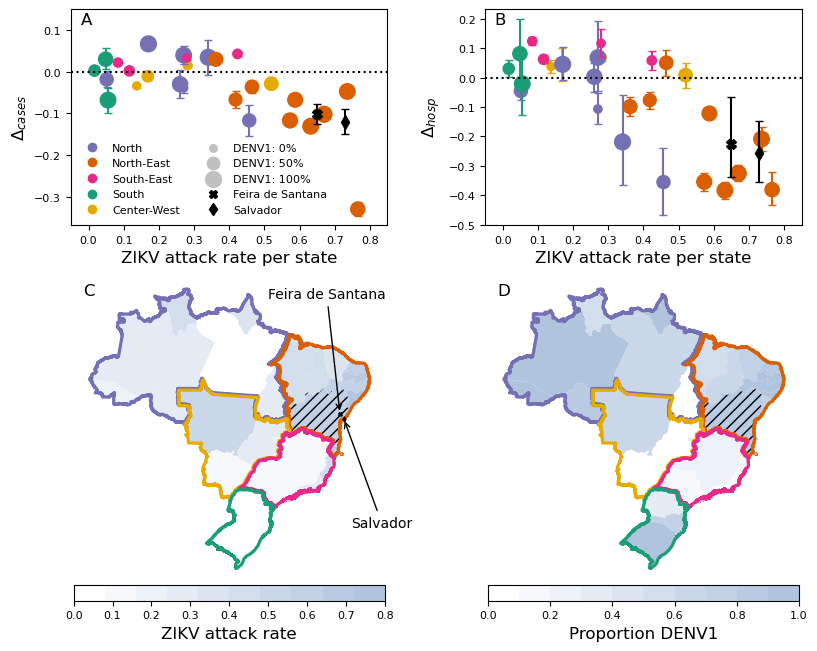

In [54]:
fig, ax = plt.subplots( constrained_layout=True, figsize = ( 8, 6 ),
                      ncols = 2, nrows = 2, sharey = False,
                      gridspec_kw={'height_ratios': [0.66,1]})

fsize_sm = 8
fsize_me = 10
fsize_lg = 12

ax1 = ax[0,0]
ax2 = ax[0,1]
ax4 = ax[1,0]
ax5 = ax[1,1]

#=== color stuff

region2color = { 'North': '#7570b3', 'North-East': '#d95f02', 'South-East': '#e7298a', 
                'South': '#1b9e77', 'Center-West': '#e6ab02'}

code2color = { code: region2color[code2region[code]] for code in props['code']}
colors = [ code2color[code] for code in  props['code'] ]

# ..,cyan, lightsteelblue
cmap = ListedColormap( ['#ffffff', '#f6f8fb', '#edf2f8', '#e5ebf4', '#dce4f0', '#d3deed', '#cad7e9', '#c2d1e5', '#b9cae2', '#b0c4de'] )


#=== D) plot proportion of DENV1

axi = ax5

divider = make_axes_locatable( axi )
caxC = divider.append_axes("bottom", size="5%", pad=0.02 )

#cax.yaxis.set_ticks([0., 0.25, 0.5, 0.75, 1.])

plot_gdf = pd.merge( gdf_uf, props[['code', 'propD1_201819']], left_on = 'SIGLA_UF', right_on = 'code' )
norm = TwoSlopeNorm( vmin = 0, vmax = 1., vcenter = 0.5 )
plot_gdf.plot( ax = axi, column = 'propD1_201819', norm = norm, cmap = cmap, cax = caxC, legend = True,
             legend_kwds={'orientation': 'horizontal'} )

plot_gdf.loc[plot_gdf['code'] == 'BA'].plot( ax = axi, hatch = '///', fc = '#DDDDDD', 
                                            ec = 'none', alpha = 0. ) # hatch Bahia

caxC.set_xlabel('Proportion DENV1', fontsize = fsize_lg)
caxC.tick_params(which = 'major', axis = 'both', labelsize = fsize_sm)

#=== C) plot attack rate ZIKV

axi = ax4

divider = make_axes_locatable(axi)
caxB = divider.append_axes("bottom", size="5%", pad=0.02 )

plot_gdf = pd.merge( gdf_uf, props[['code', 'zikv_ar_estimate']], left_on = 'SIGLA_UF', right_on = 'code' )
norm = TwoSlopeNorm( vmin = 0, vmax = 0.8, vcenter = 0.4 )
plot_gdf.plot( ax = axi, column = 'zikv_ar_estimate', norm = norm, cmap = cmap,
             cax = caxB, legend = True, 
            legend_kwds={'orientation': 'horizontal', 'shrink': 0.} )

plot_gdf.loc[plot_gdf['code'] == 'BA'].plot( ax = axi, hatch = '///', fc = '#DDDDDD', 
                                            ec = 'none', alpha = 0. ) # hatch Bahia


caxB.set_xlabel('ZIKV attack rate', fontsize = fsize_lg )
caxB.tick_params(which = 'major', axis = 'both', labelsize = fsize_sm )


# plot region contours above
cl_border = 'black'

gdf_rg1 = gdf_rg.copy()
regiao2color = { 'Norte': '#7570b3', 'Nordeste': '#d95f02', 'Sudeste': '#e7298a', 
                'Sul': '#1b9e77', 'Centro-oeste': '#e6ab02'}
for axi in [ax4, ax5]:
    for index in ['Norte', 'Nordeste', 'Centro-oeste', 'Sudeste', 'Sul']:
        tmp = gpd.GeoDataFrame( { 'geometry': [gdf_rg1.loc[index,'geometry']] } )
        #if index in ['Norte']:
        tmp = tmp.scale( xfact=0.98, yfact = 0.98 )
        tmp.plot( ax = axi, edgecolor = regiao2color[index],facecolor = 'none', linewidth = 2.3 )

# scatter cities in Bahia
point = gdf_ba[gdf_ba['NM_MUN'] == 'Feira de Santana'].centroid.values[0]
dx_, dy_ = ( -10, 16 )
ax4.annotate("Feira de Santana", xy=( point.x, point.y ), xytext=( point.x + dx_, point.y + dy_ ), 
               arrowprops=dict(arrowstyle="->"), ha='left', fontsize = fsize_me )
ax4.scatter( point.x, point.y, s = 6, marker = 'X', color = 'black' )

point = gdf_ba[gdf_ba['NM_MUN'] == 'Salvador'].centroid.values[0]
dx_, dy_ = ( 1, -15 )
ax4.annotate("Salvador", xy=( point.x, point.y ), xytext=( point.x + dx_, point.y + dy_ ), 
               arrowprops=dict(arrowstyle="->"), ha='left', fontsize = fsize_me )
ax4.scatter( point.x, point.y, s = 6, marker = 'd', color = 'black' )


#=== A,B) scatterplots

# read data
df_cases = pd.read_csv( 'c_age_diff_stats_mainfigure.csv')
df_hosp  = pd.read_csv( 'h_age_diff_stats_mainfigure.csv')

ax_tmp = [ax1, ax2]

for iax, dx in enumerate( [ df_cases, df_hosp ] ):
    
    dx = dx.loc[dx['place_type'] == 'state'].copy() # select states only
    dx['code'] = dx['name'].map( name2code )
    dx = pd.merge( dx, props[['code', 'propD1_201819', 'zikv_ar_estimate']], on = 'code') # add propD1
    
    axi = ax_tmp[iax]
    
    for region in ['Center-West', 'North', 'North-East', 'South', 'South-East']:
        
        color = region2color[region]
        codes_tmp = [code for code, region0 in code2region.items() if region0 == region ]
        
        dx1 = dx.loc[ dx['code'].isin( codes_tmp ) ].copy()
        
        #if iax == 1: # remove TO
        #    print( dx1[dx1['code'] == 'TO'] )
        #    dx1 = dx1[dx1['code'] != 'TO']
            
        xx = dx1.loc[:, 'zikv_ar_estimate'].values
        yy = dx1.loc[:, 'mean_age_diff'].values
        yy_lo = dx1.loc[:, 'perc_lo_age_diff'].values
        yy_hi = dx1.loc[:, 'perc_hi_age_diff'].values
        yyerr = np.vstack( [ yy - yy_lo, yy_hi - yy ] )
        sizes = 30 + 100 * dx1.loc[:,'propD1_201819'].values
        axi.scatter( xx, yy, color = color, marker = 'o', s = sizes )
        axi.errorbar( xx, yy, yerr = yyerr, color = color, marker = None, ls = '', capsize = 3, zorder = 1 )

       
    axi.axhline( y = 0, color = 'black', ls = ':')

ax1.set_ylabel( r'$\Delta_{cases}$', fontsize = fsize_lg )
ax2.set_ylabel( r'$\Delta_{hosp}$', fontsize = fsize_lg )

ax1.set_xlabel('ZIKV attack rate per state', fontsize = fsize_lg )
ax2.set_xlabel('ZIKV attack rate per state', fontsize = fsize_lg )

ax1.set_ylim( top = 0.15 )

# plot Salvador data
# note: seroprevalence = 0.73 (see Rodriguez-Barraquer, Science)

for iax, dx in enumerate( [ df_cases, df_hosp ] ):
    mean    = dx.loc[ dx['name'] == 'salvador', 'mean_age_diff'].values[0]
    perc_lo = dx.loc[ dx['name'] == 'salvador', 'perc_lo_age_diff'].values[0]
    perc_hi = dx.loc[ dx['name'] == 'salvador', 'perc_hi_age_diff'].values[0]

    yerr = np.array([ mean - perc_lo, perc_hi - mean ])[:,None]

    ax_tmp[iax].errorbar( 0.73, mean, yerr = yerr,  marker = 'd', 
                 color = 'black', zorder = 2, capsize = 3, ms = 7 )

# plot Feira de Santana data
# note: seroprevalence = 0.65 (see Lourenco, eLife)

for iax, dx in enumerate( [ df_cases, df_hosp ] ):
    mean    = dx.loc[ dx['name'] == 'feira_de_santana', 'mean_age_diff'].values[0]
    perc_lo = dx.loc[ dx['name'] == 'feira_de_santana', 'perc_lo_age_diff'].values[0]
    perc_hi = dx.loc[ dx['name'] == 'feira_de_santana', 'perc_hi_age_diff'].values[0]

    yerr = np.array([ mean - perc_lo, perc_hi - mean ])[:,None]

    ax_tmp[iax].errorbar( 0.65, mean, yerr = yerr,  marker = 'X', 
                 color = 'black', zorder = 2, capsize = 3, ms = 7 )

#== formatting

handles = [Line2D([0],[0],ls='',marker='o', color=color) for region, color in region2color.items()]
handles += [plt.scatter([], [], marker='o', color='silver', s = 30),
            plt.scatter([], [], marker='o', color='silver', s = 80),
            plt.scatter([], [], marker='o', color='silver', s = 130),
            Line2D([0],[0],ls='',marker='X', color='black'),
            Line2D([0],[0],ls='',marker='d', color='black')]
labels = [region for region, color in region2color.items()]
labels += ['DENV1: 0%', 'DENV1: 50%', 'DENV1: 100%','Feira de Santana','Salvador']

#ax1.set_ylim(-0.4,0.12)
ax1.legend( handles = handles, labels = labels, framealpha = False, fontsize = fsize_sm, ncol = 2 )

for iax, axi in enumerate( [ ax1, ax2 ] ):
    axi.tick_params( which = 'major', axis = 'both', labelsize = fsize_sm  )

letters = ['A', 'B']
for iax, axi in enumerate( [ ax1, ax2 ] ):
    axi.set_xlim( -0.05, 0.85 )
    axi.text( 0.03, 0.93, letters[iax], fontsize = fsize_lg, transform = axi.transAxes )


ax4.text( 0.03, 0.93, 'C', fontsize = fsize_lg, transform = ax4.transAxes )
ax5.text( 0.03, 0.93, 'D', fontsize = fsize_lg, transform = ax5.transAxes )

ax4.axis('off')
ax5.axis('off')

## Supplementary plots

Calculate the time series of mean age for both hospitalisation and case counts

In [56]:
# compute mean age time series for hospitalisations

nreps = 1000

year_min, year_max = 2001, 2020
years_analysis = range( year_min, year_max )


df = pd.read_csv( '../data/h_age_uf_0020.csv' )
dpop = pd.read_csv( '../data/population_unidade_sinan_clean.csv' )
age_cols = age_cols_h.copy()
agebins = agebins_h.copy()
res_h = { col: { code: [] for code in code2name.keys() } for col in ['age_mean', 
                                                                     'age_lo', 
                                                                     'age_hi', 
                                                                     'cases'] }
for code, name in code2name.items():
    
    name = code2name[code]
    print( code )

    for year in years_analysis:
        
        histo = df.loc[ (df['year'] == year) & (df['code'] == code), age_cols].sum( axis = 0 )
        
        cases = histo.sum() # get all cases

        ages_bootstrap = estimate_mean_age_bootstrap( histo[:-1], agebins[:-1], nreps )

        #popsize = dpop.loc[ dpop['District'] == name, str(year) ].values[0]
        res_h['cases'][code].append( cases )
        res_h['age_mean'][code].append( ages_bootstrap.mean() )
        res_h['age_lo'][code].append( np.percentile( a = ages_bootstrap, q = 2.5 ) )                
        res_h['age_hi'][code].append( np.percentile( a = ages_bootstrap, q = 97.5 ) ) 

AC
AL
AP
AM
BA
CE
DF
ES
GO
MA
MT
MS
MG
PA
PB
PR
PE
PI
RJ
RN
RS
RO
RR
SC
SP
SE
TO


In [57]:
# save results
if True:
    df = pd.DataFrame( res_h )
    df.to_csv( 'h_age_mean_time_series_uf_200119.csv', index = True )
    print( 'Saved!' )

Saved!


In [58]:
# compute mean age time series for cases

nreps = 1000

year_min, year_max = 2001, 2020
years_analysis = range( year_min, year_max )


df = pd.read_csv( '../data/c_age_uf_0120.csv' )
dpop = pd.read_csv( '../data/population_unidade_sinan_clean.csv' )
age_cols = age_cols_c.copy()
agebins = agebins_c.copy()
res_c = { col: { code: [] for code in code2name.keys() } for col in ['age_mean', 
                                                                     'age_lo', 
                                                                     'age_hi', 
                                                                     'cases'] }
for code, name in code2name.items():
    
    name = code2name[code]
    print( code )

    for year in years_analysis:
        
        histo = df.loc[ (df['year'] == year) & (df['code'] == code), age_cols].sum( axis = 0 )
        
        cases = histo.sum() # get all cases

        ages_bootstrap = estimate_mean_age_bootstrap( histo[:-1], agebins[:-1], nreps )

        #popsize = dpop.loc[ dpop['District'] == name, str(year) ].values[0]
        res_c['cases'][code].append( cases )
        res_c['age_mean'][code].append( ages_bootstrap.mean() )
        res_c['age_lo'][code].append( np.percentile( a = ages_bootstrap, q = 2.5 ) )                
        res_c['age_hi'][code].append( np.percentile( a = ages_bootstrap, q = 97.5 ) ) 

AC
AL
AP
AM
BA
CE
DF
ES
GO
MA
MT
MS
MG
PA
PB
PR
PE
PI
RJ
RN
RS
RO
RR
SC
SP
SE
TO


In [59]:
# save results
if True:
    df = pd.DataFrame( res_c )
    df.to_csv( 'c_age_mean_time_series_uf_200119.csv', index = True )
    print( 'Saved!' )

Saved!


Calculate the time series of age shifts

In [60]:
# Compute mean age variation before and after ZIKV for hospitalizations

base_path = '../data'

nreps = 1000

dy1, dy2, dy3 = 3, 3, 2 # dy1: delay, dy2: number of days pre period, dy3: number of days post
year_min, year_max = 2001, 2020
years_analysis = range( year_min + dy2, year_max - dy3 + 1 )

res_h = { col: { code: [] for code in code2name.keys() } for col in ['age_pre_mean', 'age_pre_lo', 'age_pre_hi', 'age_post_mean',
       'age_post_lo', 'age_post_hi', 'age_diff_mean', 'age_diff_lo',
       'age_diff_hi', 'cases_pre', 'cases_post']}

# read data
df = pd.read_csv( '../data/h_age_uf_0020.csv' )

for code, name in code2name.items():
    
    name = code2name[code]
    print( code )
    
    for year in years_analysis:
        
        years_pre = np.arange( max( year_min, year - dy1 - dy2 + 1 ), year - dy2 + 1 )
        years_post = np.arange( year, min( year_max, year + dy3 ) )
        
        histo_pre = df.loc[ ( df['year'].isin( years_pre ) ) & ( df['code'] == code ), age_cols_h ].sum( axis = 0 )
        histo_post = df.loc[ ( df['year'].isin( years_post ) ) & ( df['code'] == code ), age_cols_h ].sum( axis = 0 )
        
        n_pre, n_post = histo_pre.sum(), histo_post.sum()
        
        ages_pre  = estimate_mean_age_bootstrap( histo_pre[:-1], agebins_h[:-1], nreps )
        ages_post = estimate_mean_age_bootstrap( histo_post[:-1], agebins_h[:-1], nreps )
        ages_diff = ages_post / ages_pre - 1

        res_h['cases_pre'][code].append( n_pre )
        res_h['cases_post'][code].append( n_post )
    
        res_h['age_pre_mean'][code].append( ages_pre.mean() )
        res_h['age_pre_lo'][code].append( np.percentile( a = ages_pre, q = 2.5 ) )                
        res_h['age_pre_hi'][code].append( np.percentile( a = ages_pre, q = 97.5 ) ) 
        
        res_h['age_post_mean'][code].append( ages_post.mean() )
        res_h['age_post_lo'][code].append( np.percentile( a = ages_post, q = 2.5 ) )                
        res_h['age_post_hi'][code].append( np.percentile( a = ages_post, q = 97.5 ) ) 
        
        res_h['age_diff_mean'][code].append( ages_diff.mean() )
        res_h['age_diff_lo'][code].append( np.percentile( a = ages_diff, q = 2.5 ) )                
        res_h['age_diff_hi'][code].append( np.percentile( a = ages_diff, q = 97.5 ) )

AC
AL
AP
AM
BA
CE
DF
ES
GO
MA
MT
MS
MG
PA
PB
PR
PE
PI
RJ
RN
RS
RO
RR
SC
SP
SE
TO


In [61]:
# save results
if True:
    df = pd.DataFrame( res_h )
    df.to_csv( 'h_age_diff_uf_200119.csv', index = True )
    print('Saved!')

Saved!


In [62]:
# Compute mean age variation before and after ZIKV for cases
nreps = 1000

dy1, dy2, dy3 = 3, 3, 2 # dy1: delay, dy2: number of days pre period, dy3: number of days post
year_min, year_max = 2001, 2020
years_analysis = range( year_min + dy2, year_max - dy3 + 1 )

res_c = { col: { code: [] for code in code2name.keys() } for col in ['age_pre_mean', 'age_pre_lo', 'age_pre_hi', 'age_post_mean',
       'age_post_lo', 'age_post_hi', 'age_diff_mean', 'age_diff_lo',
       'age_diff_hi', 'cases_pre', 'cases_post']}

# read data
df = pd.read_csv( '../data/c_age_uf_0120.csv' )

for code, name in code2name.items():
    
    name = code2name[code]
    print( code )
    
    for year in years_analysis:
        
        years_pre = np.arange( max( year_min, year - dy1 - dy2 + 1 ), year - dy2 + 1 )
        years_post = np.arange( year, min( year_max, year + dy3 ) )
        
        histo_pre = df.loc[ ( df['year'].isin( years_pre ) ) & ( df['code'] == code ), age_cols_c ].sum( axis = 0 )
        histo_post = df.loc[ ( df['year'].isin( years_post ) ) & ( df['code'] == code ), age_cols_c ].sum( axis = 0 )
        
        n_pre, n_post = histo_pre.sum(), histo_post.sum()
        
        ages_pre  = estimate_mean_age_bootstrap( histo_pre[:-1], agebins_c[:-1], nreps )
        ages_post = estimate_mean_age_bootstrap( histo_post[:-1], agebins_c[:-1], nreps )
        ages_diff = ages_post / ages_pre - 1

        res_c['cases_pre'][code].append( n_pre )
        res_c['cases_post'][code].append( n_post )
    
        res_c['age_pre_mean'][code].append( ages_pre.mean() )
        res_c['age_pre_lo'][code].append( np.percentile( a = ages_pre, q = 2.5 ) )                
        res_c['age_pre_hi'][code].append( np.percentile( a = ages_pre, q = 97.5 ) ) 
        
        res_c['age_post_mean'][code].append( ages_post.mean() )
        res_c['age_post_lo'][code].append( np.percentile( a = ages_post, q = 2.5 ) )                
        res_c['age_post_hi'][code].append( np.percentile( a = ages_post, q = 97.5 ) ) 
        
        res_c['age_diff_mean'][code].append( ages_diff.mean() )
        res_c['age_diff_lo'][code].append( np.percentile( a = ages_diff, q = 2.5 ) )                
        res_c['age_diff_hi'][code].append( np.percentile( a = ages_diff, q = 97.5 ) )

AC
AL
AP
AM
BA
CE
DF
ES
GO
MA
MT
MS
MG
PA
PB
PR
PE
PI
RJ
RN
RS
RO
RR
SC
SP
SE
TO


In [63]:
# save results
if True:
    df = pd.DataFrame( res_c )
    df.to_csv( 'c_age_diff_uf_200119.csv', index = True )
    print('Saved!')

Saved!


### Plot the time series of mean age for both hospitalisation and case counts

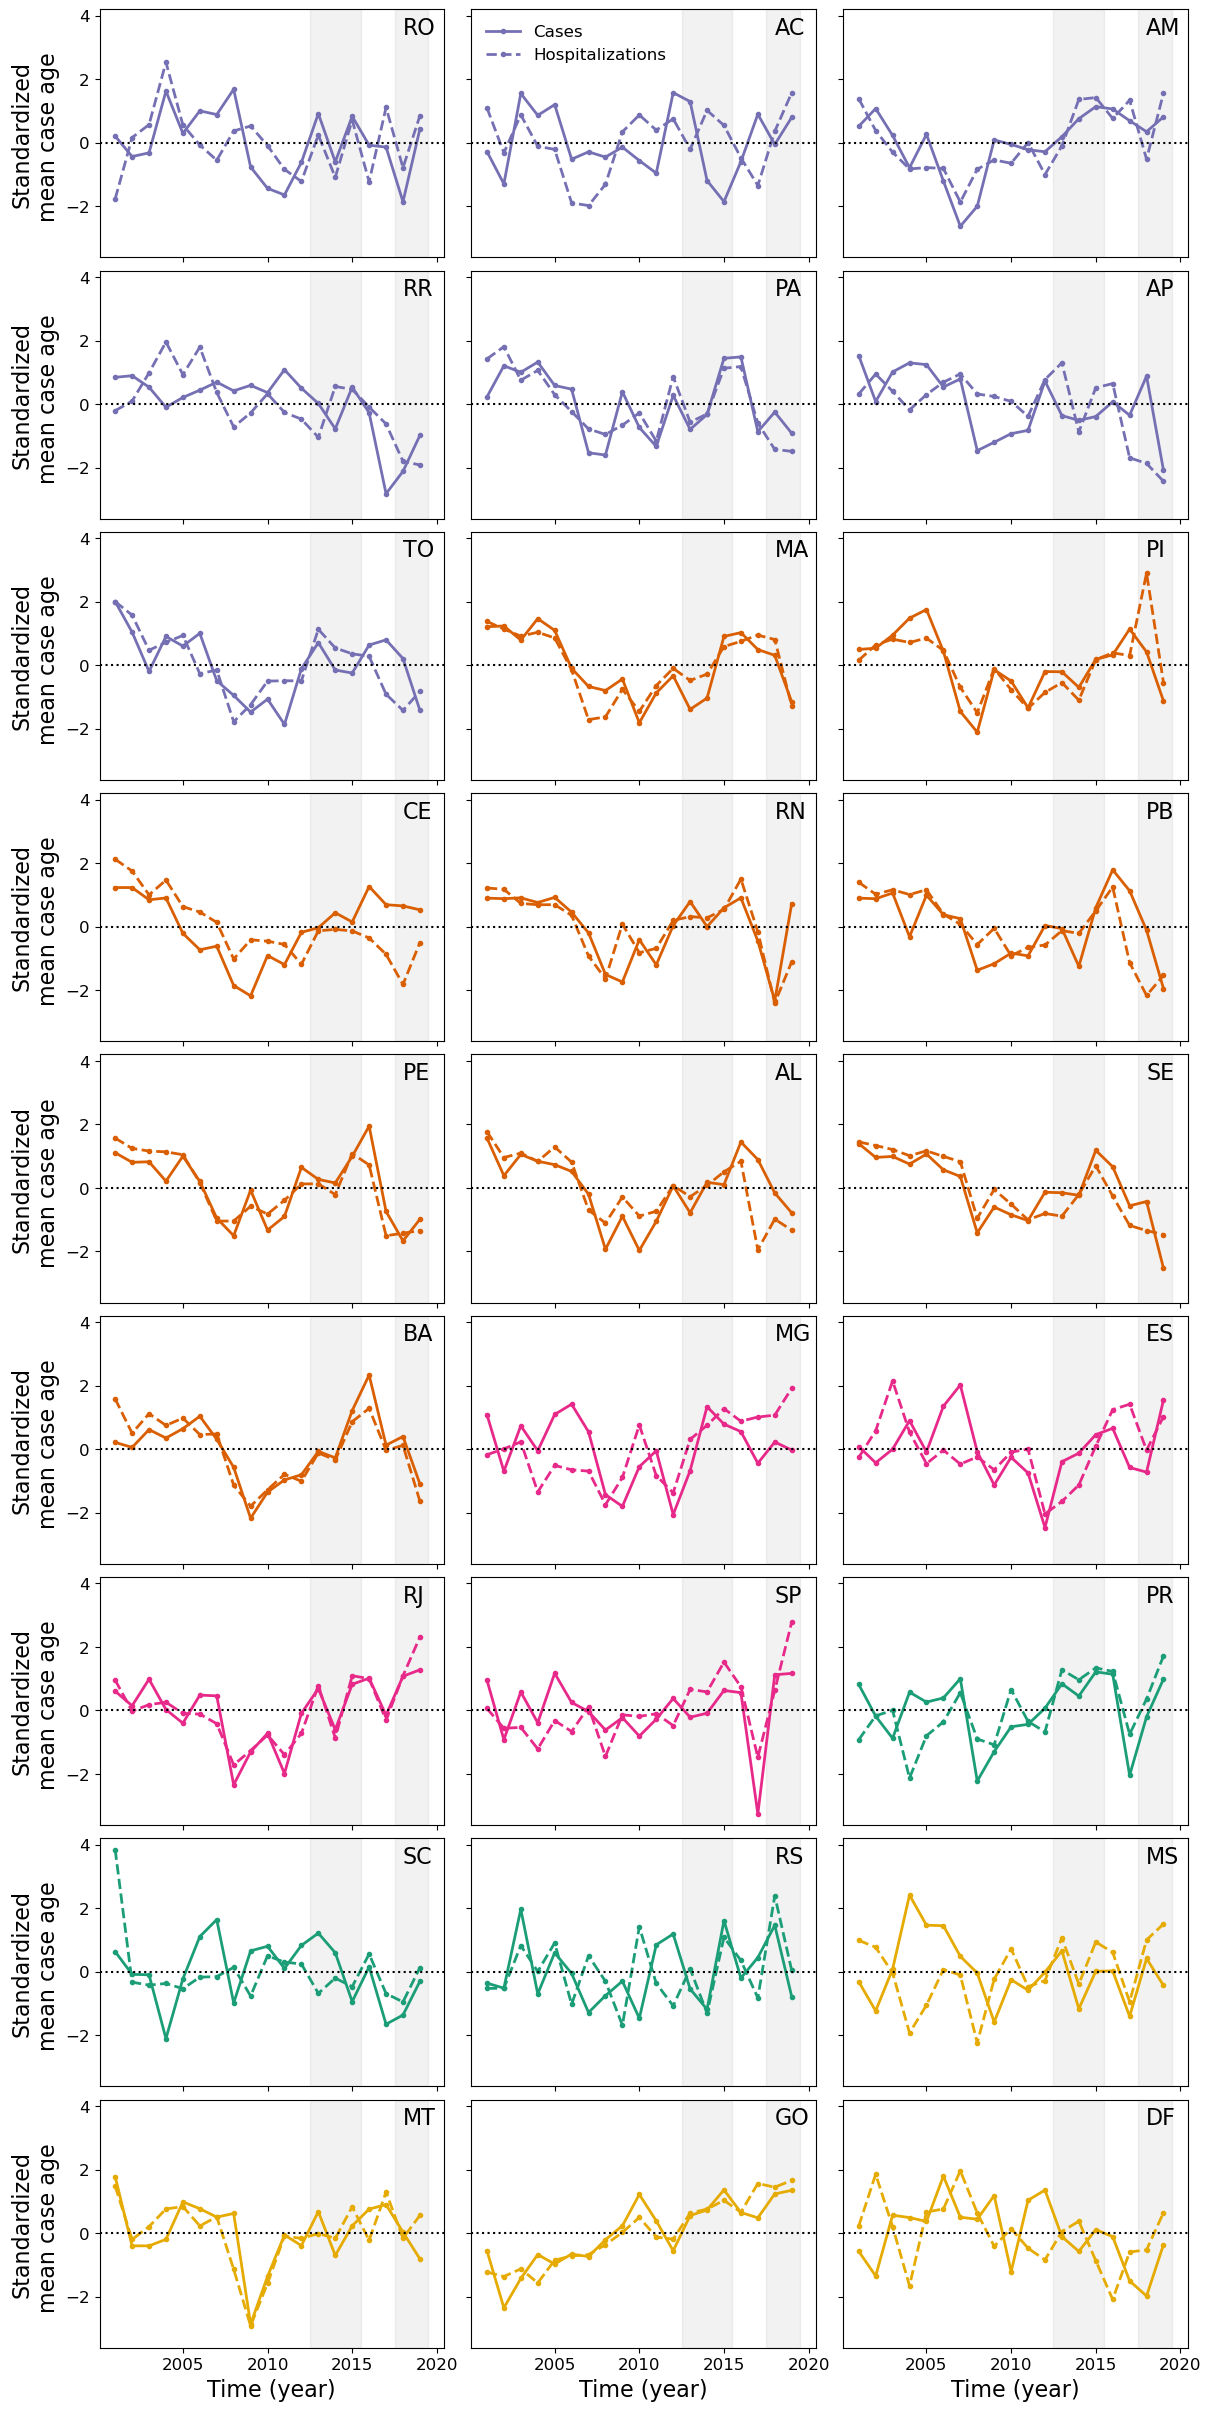

In [64]:
fig, ax = plt.subplots( figsize = ( 12, 24 ), nrows = 9, ncols = 3, 
                       sharey = True, sharex = True, constrained_layout = True )

region2color = { 'North': '#7570b3', 'North-East': '#d95f02', 'South-East': '#e7298a', 
                'South': '#1b9e77', 'Center-West': '#e6ab02'}
code2color = { code: region2color[code2region[code]] for code in code2name.keys()}
colors = [ code2color[code] for code in code2name.keys() ]

counter = 0
lw = 2

age_c  = pd.read_csv('./c_age_mean_time_series_uf_200119.csv', index_col = 0 )
age_h  = pd.read_csv('./h_age_mean_time_series_uf_200119.csv', index_col = 0 )
xx = np.arange( 2001, 2020 )


for region, color in region2color.items():
    
    for code in codes_by_region[region]:
        
        axi = ax.flatten()[counter]

        age_mean_c = [float(el) for el in age_c.loc[code, 'age_mean'][1:-1].split(',')]
        age_mean_c_std = ( age_mean_c - np.mean( age_mean_c ) ) / np.std( age_mean_c )
        axi.plot( xx, age_mean_c_std, color = color, marker = '.', ls = '-',  lw = lw, label = 'Cases' )
        
        age_mean_h = [float(el) for el in age_h.loc[code, 'age_mean'][1:-1].split(',')]
        age_mean_h_std = ( age_mean_h - np.mean( age_mean_h ) ) / np.std( age_mean_h )
        axi.plot( xx, age_mean_h_std, color = color, marker = '.', ls = '--',  lw = lw, label = 'Hospitalizations' )

        axi.axhline( y = 0., color = 'black', ls = ':' )
        
        axi.text( 0.88, 0.9, code, fontsize = 16, transform = axi.transAxes )
        #axi.set_title( code, fontsize = 16 )
        
        counter += 1

#=== Final formatting

ax[0,1].legend( framealpha = False, fontsize = 12, loc = 'upper left' )
    
for axi in ax[:,0]:
    axi.set_ylabel( 'Standardized\nmean case age ', fontsize = 16 )
    
for axi in ax[-1,:]:
    axi.set_xlabel( 'Time (year)', fontsize = 16 )
    
for axi in ax.flatten():
    #axi.axhline( y = 0, ls = ':', color = 'grey')
    axi.tick_params( which = 'major', axis = 'both', labelsize = 12 )
    
    axi.axvspan( 2012.5, 2015.5, color = 'grey', alpha = 0.1 )
    axi.axvspan( 2017.5, 2019.5, color = 'grey', alpha = 0.1 )
    


###  Plot the time series of age shifts

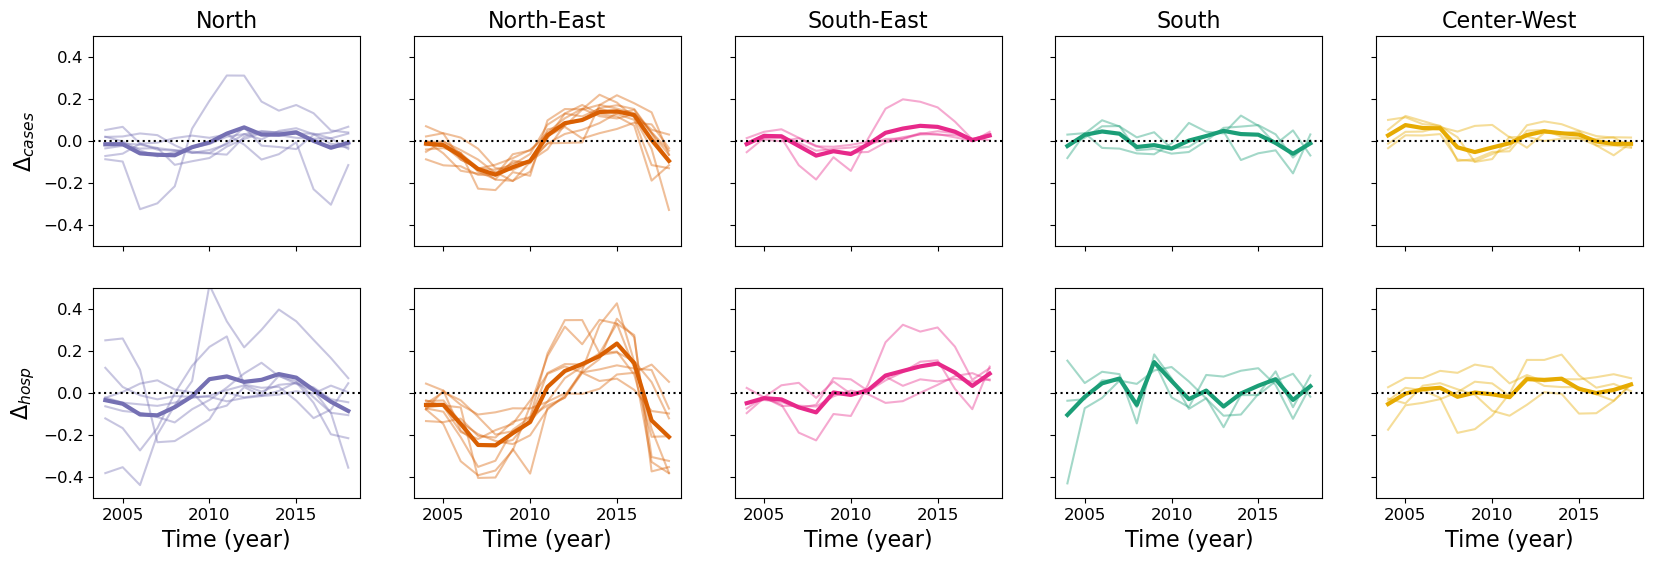

In [65]:
# now plot the age shift over time

fig, ax = plt.subplots( figsize = ( 20, 6 ), ncols = 5, nrows = 2, sharey = True, sharex = True )


dy1, dy2, dy3 = 3, 3, 2 # dy1: delay, dy2: number of days pre period, dy3: number of days post

region2ax = { region: i for i, 
             region in enumerate( ['North', 'North-East', 'South-East', 'South', 'Center-West'] )}

get_vals = lambda df, code: df.loc[code, 'age_diff_mean'][1:-1].split(',')

# plot cases
years_analysis_dp = range( 2001 + dy2, 2020 - dy3 + 1 )
diff_dp = pd.read_csv( './c_age_diff_uf_200119.csv', index_col = 0)
for region, ufs in codes_by_region.items():
    for code in ufs:
        vals = [ float( el ) for el in get_vals( diff_dp, code ) ]
        ax[ 0, region2ax[region] ].plot( years_analysis_dp, vals, color = code2color[code], alpha = 0.4 )
        
    vals = np.array( [ [float( el ) for el in get_vals( diff_dp, code )] for code in ufs ] )
    ax[0, region2ax[region] ].plot( years_analysis_dp, vals.mean( axis = 0 ), color = code2color[code], lw = 3 )
    
    ax[0, region2ax[region] ].set_title( region, fontsize = 16 )
    
# plot hospitalisations
years_analysis_dc = range( 2001 + dy2, 2020 - dy3 + 1 )
diff_dc = pd.read_csv( 'h_age_diff_uf_200119.csv', index_col = 0)
for region, ufs in codes_by_region.items():
    for code in ufs:
        vals = [ float( el ) for el in get_vals( diff_dc, code ) ]
        ax[ 1, region2ax[region] ].plot( years_analysis_dc, vals, color = code2color[code], alpha = 0.4 )
        
    vals = np.array( [ [float( el ) for el in get_vals( diff_dc, code )] for code in ufs ] )
    ax[1, region2ax[region] ].plot( years_analysis_dc, vals.mean( axis = 0 ), color = code2color[code], lw = 3 )
    
    
ax[0,0].set_ylim( -0.5, 0.5 )

ax[0,0].set_ylabel( r'$\Delta_{cases}$', fontsize = 16 )
ax[1,0].set_ylabel( r'$\Delta_{hosp}$', fontsize = 16 )

for axi in ax.flatten():
    axi.tick_params( which = 'major', axis = 'both', labelsize = 12 )
    axi.axhline( y = 0, ls = ':', color = 'black' )
    
for axi in ax[1]:
    axi.set_xlabel( 'Time (year)', fontsize = 16 )

### Sensitivity of age shift when different pre-ZIKV periods are considered 

Uses different 3-year-long periods to estimate mean case age before ZIKV.
Plot also the correlation of resulting age shift with ZIKV attack rate by state.

In [66]:
dfc = pd.read_csv( 'c_age_diff_slidingwindow.csv', index_col = 0 )
dfh = pd.read_csv( 'h_age_diff_slidingwindow.csv', index_col = 0 )

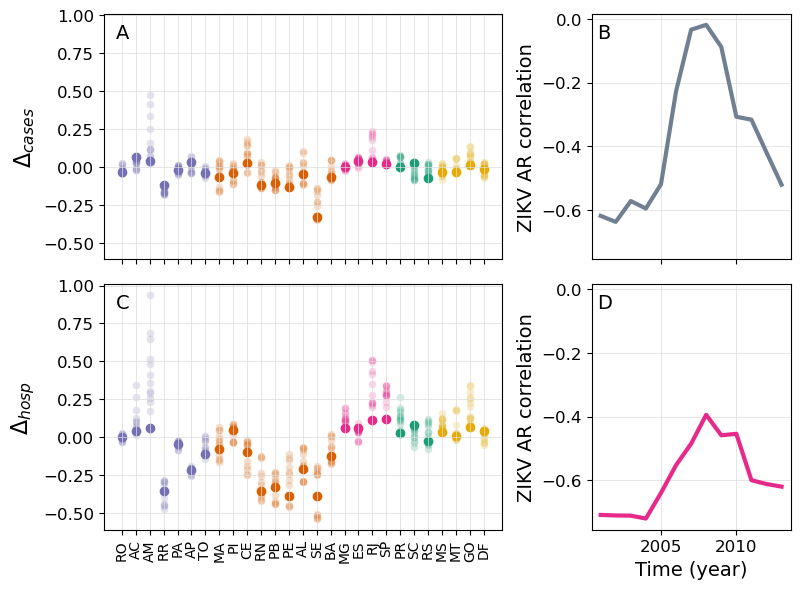

In [67]:
fig, ax = plt.subplots( figsize = ( 8, 6 ), ncols = 2, nrows = 2,
                      constrained_layout = False, sharex = 'col', sharey = 'col',
                      gridspec_kw={'width_ratios': [1, 0.5]})

#=== color stuff

region2color = { 'North': '#7570b3', 'North-East': '#d95f02', 'South-East': '#e7298a', 
                'South': '#1b9e77', 'Center-West': '#e6ab02'}

code2color = { code: region2color[code2region[code]] for code in name2code.values()}
colors = [ code2color[code] for code in  name2code.values() ]

color_h = '#e7298a'
color_c = 'slategray'
colors_ch = [color_c, color_h]


years_analysis = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013']

yyears = [int(year) for year in years_analysis]

zikv_ar = []
for name in dfh.index:
    zikv_ar.append( zikv_ar_perkins[name2code[name]])



for i, df in enumerate( [ dfc, dfh ] ):
    
    #== raw Δ by state
    
    counter = 0
    codes_ordered = []
    for region, color in region2color.items():
        for code in codes_by_region[region]:
            tmp = df.loc[ code2name[code] ].values
            T = len( tmp )
            ax[i,0].scatter( [counter]*(T-1), tmp[:-1], color = color, alpha = 0.2,
                           linewidth = 0, s = 30 )
            ax[i,0].scatter( counter, tmp[-1], color = color, alpha = 1 )

            counter += 1
            codes_ordered.append( code )
    
    #== correlation
    sph = [ spearmanr( zikv_ar, df[year].values )[0] for year in years_analysis ]
    ax[i,1].plot( yyears, sph, lw = 3, color = colors_ch[i] )
    
ax[0,0].set_ylabel( r'$\Delta_{cases}$', fontsize = 16 )
ax[1,0].set_ylabel( r'$\Delta_{hosp}$', fontsize = 16 )
ax[0,1].set_ylabel( r'ZIKV AR correlation', fontsize = 14 )
ax[1,1].set_ylabel( r'ZIKV AR correlation', fontsize = 14 )
ax[1,1].set_xlabel( 'Time (year)', fontsize = 14 )

ax[1,0].set_xticks( range( len( codes_ordered ) ) )
ax[1,0].set_xticklabels( codes_ordered )

labels = "ABCD"
for iax, axi in enumerate( ax.flatten() ):
    axi.tick_params( which = 'major', axis = 'both', labelsize = 12 )
    axi.grid( lw = 0.5, c = 'gainsboro', zorder = -1 )
    axi.text( 0.03, 0.9, labels[iax], transform = axi.transAxes, fontsize = 14)
    
ax[1,0].tick_params( which = 'major', axis = 'x', labelsize = 10, rotation = 90 )

plt.tight_layout()

## Plot cumulative age distributions in Northeastern states

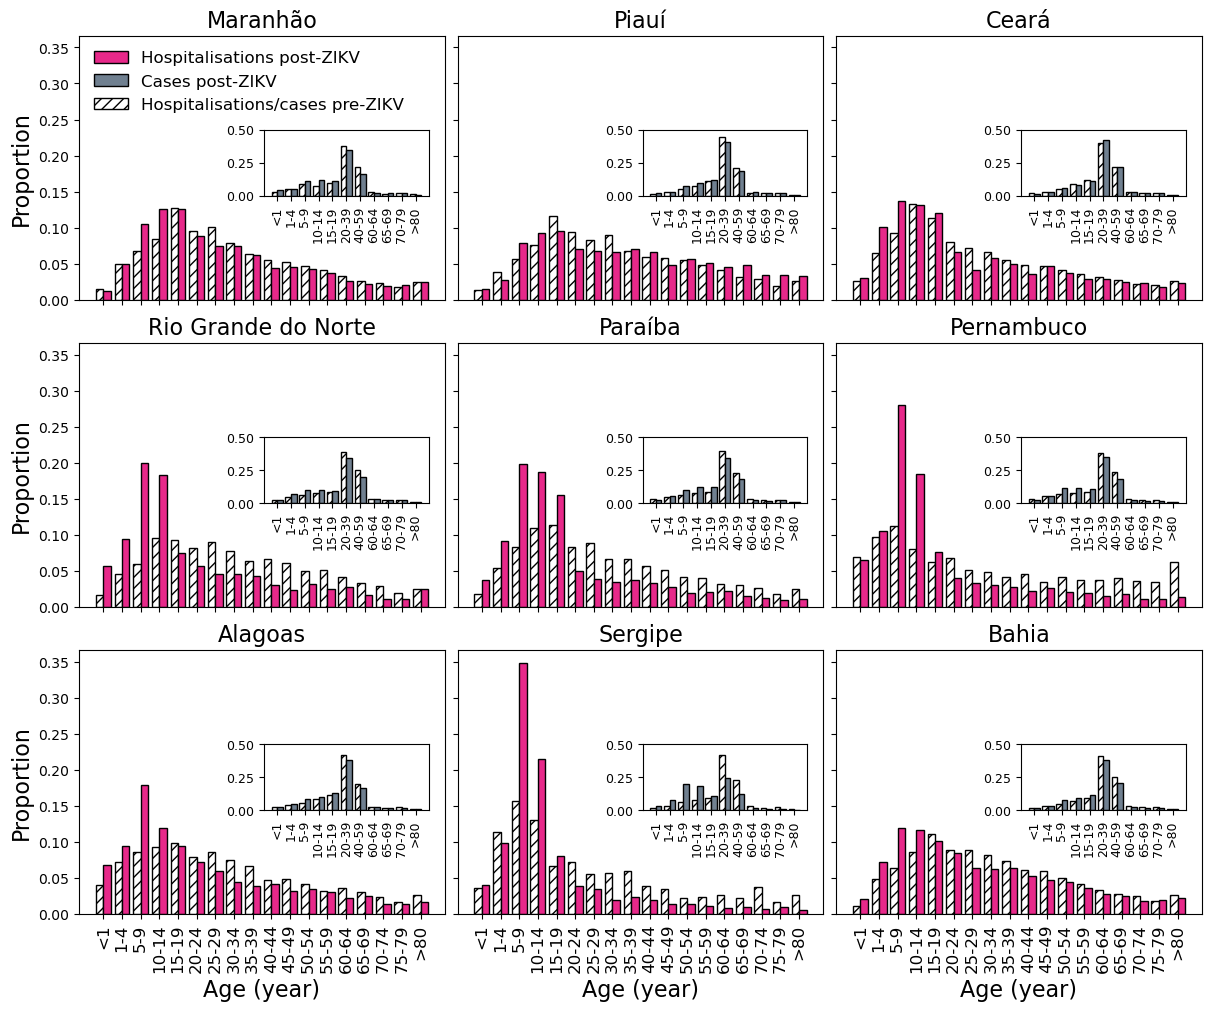

In [13]:
fig, ax = plt.subplots( figsize = ( 12, 10 ), ncols = 3, nrows = 3, sharex=True, sharey = True,
                      constrained_layout = True )


color_h = '#e7298a'
color_c = 'slategray'
width = 0.4

#== plot hospitalizations
for i, name in enumerate( districts_by_region['North-East'] ):
    
    axi = ax.flatten()[i]

    # read hosp data
    fname = '../data/h_{}_post2007_sus_clean.csv'.format( label2name[name] )
    df = pd.read_csv( os.path.join( base_path, fname ), sep=',')
       
    tmp_inc_pre  = df.loc[df['year'].isin([ 2013, 2014, 2015]), age_cols_h].sum( axis = 0 )
    tmp_inc_post = df.loc[df['year'].isin([ 2018, 2019 ]), age_cols_h].sum( axis = 0 )
    
    histo_pre  = ( tmp_inc_pre / tmp_inc_pre.sum() )
    histo_post = ( tmp_inc_post / tmp_inc_post.sum() )
    
    xx1 = np.arange( len( age_cols_h ) ) - 0.5 * width
    xx2 = np.arange( len( age_cols_h ) ) + 0.5 * width
    
    axi.bar( xx1, histo_pre, width = width, hatch = '///',
              edgecolor = 'black', facecolor = 'none', label = 'Hosp., pre-ZIKV' )
    axi.bar( xx2, histo_post, width = width,
              edgecolor = 'black', facecolor = color_h, label = 'Hosp., post-ZIKV' )
   
    
    axi.set_title( name, fontsize = 16 )

#== plot cases (within inset)


for i, name in enumerate( districts_by_region['North-East'] ):
    
    axi = ax.flatten()[i]
    code = label2code[name]    

    ax_inset = inset_axes(axi, height='100%', width='100%', bbox_to_anchor = ( 0.525, 0.42, 0.45, 0.25 ),
                         bbox_transform = axi.transAxes )
    
      # read hosp data
    fname = '../data/c_{}_post2013_sinan_clean.csv'.format( label2name[name] )
    df = pd.read_csv( os.path.join( base_path, fname ), sep=',')
       
    tmp_inc_pre  = df.loc[df['year'].isin([ 2013, 2014, 2015]), age_cols_c].sum( axis = 0 )
    tmp_inc_post = df.loc[df['year'].isin([ 2018, 2019 ]), age_cols_c].sum( axis = 0 )
    
    histo_pre  = ( tmp_inc_pre / tmp_inc_pre.sum() )
    histo_post = ( tmp_inc_post / tmp_inc_post.sum() )
    
    xx1 = np.arange( len( age_cols_c ) ) - 0.5 * width
    xx2 = np.arange( len( age_cols_c ) ) + 0.5 * width
    
    ax_inset.bar( xx1, histo_pre, width = width, hatch = '///',
              edgecolor = 'black', facecolor = 'none' )
    ax_inset.bar( xx2, histo_post, width = width,
              edgecolor = 'black', facecolor = color_c )
           
    #ax_inset.set_yticks( [0., 0.5, 1] )
    ax_inset.set_ylim( 0, 0.5 ) 
    ax_inset.tick_params( which = 'major', axis = 'x', rotation = 90 )
    ax_inset.tick_params( which = 'major', axis = 'both', labelsize = 9 )
    
    
    ax_inset.set_xticks( np.arange( len( age_cols_c ) ) )
    ax_inset.set_xticklabels( age_cols_c )
    
    

ax[0,0].legend( handles = [ Rectangle([0,0],0,0, fc=color_h, ec='black'),
                            Rectangle([0,0],0,0, fc=color_c, ec='black'),
                            Rectangle([0,0],0,0, fc='none', ec='black', hatch='///')],
                labels = ['Hospitalisations post-ZIKV', 'Cases post-ZIKV', 'Hospitalisations/cases pre-ZIKV'],
                framealpha = False, fontsize = 12, loc = 'upper left',
                handlelength = 2 )

for axi in ax[:,0]:
    axi.set_ylabel( 'Proportion', fontsize = 16 )
    
for axi in ax[-1,:]:
    axi.set_xlabel( 'Age (year)', fontsize = 16 )
    axi.set_xticks( np.arange( len( age_cols_h ) ) )
    axi.set_xticklabels( age_cols_h )
    axi.tick_params( which = 'major', axis = 'x', rotation = 90 )
    
letters = ['A','B','C','D','E','F','G','H','I']
for iax, axi in enumerate( ax.flatten() ):
    axi.tick_params( which = 'major', axis = 'x', labelsize = 12)
    #axi.text( 0.02, 0.9, letters[iax], fontsize = 16, transform = axi.transAxes )

## Reduction in incidence, ZIKV attack rate, age shift

Using yearly incidence data

In [70]:
def read_incidence( path, name, inctype ):
    
    tmp = []
    if inctype == 'c':
        periods = ['pre2007', '0713', 'post2013']
        db = 'sinan'
    else:
        periods = ['pre2007', 'post2007']
        db = 'sus'
        
    for period in periods:
        path_tmp = os.path.join( path, 
                                '{}_{}_{}_{}_clean.csv'.format( inctype, name, period, db ))
        df = pd.read_csv( path_tmp )
        tmp.append( df )
    
    return pd.concat( tmp )

In [71]:
dpop = pd.read_csv( '../data/population_unidade_sinan_clean.csv' )

region2color = { 'North': '#7570b3', 'North-East': '#d95f02', 'South-East': '#e7298a', 
                'South': '#1b9e77', 'Center-West': '#e6ab02'}

code2color = { code: region2color[code2region[code]] for code in code2region.keys() }

#years_pre = list( range( 2008, 2016 ) )
years_pre = list( range( 2010, 2016 ) )

years_post = [2016, 2017]

years_pre_str = [str(yy) for yy in years_pre]
years_post_str = [str(yy) for yy in years_post]

res = { 'delta_inc': [], 'zikv_ar': [], 'color': [] }

for code, name in code2name.items():
    #== get cases
    #df = read_incidence( '../../../data/sus_new', name, 'c' )
    #df['total'] = df[age_cols_c].sum( axis = 1 )
    
    df = read_incidence( '../data', name, 'h' )
    df['total'] = df[age_cols_h].sum( axis = 1 )
    
    #== get population
    pop = dpop.loc[dpop['District'] == name]

    #== normalise incidence
    inc_pre = df.loc[df['year'].isin( years_pre ), 'total'] / pop.loc[:,years_pre_str].values[0]
    inc_post = df.loc[df['year'].isin( years_post ), 'total'] / pop.loc[:,years_post_str].values[0]
    
    #delta_inc = inc_post.mean() / inc_pre.mean() - 1.
    delta_inc = np.sqrt( inc_post ).mean() / np.sqrt( inc_pre ).mean() - 1.
    
    #== get zikv attack rate
    zikvAR = zikv_ar_perkins[code]
    
    res['delta_inc'].append( delta_inc )
    res['zikv_ar'].append( zikvAR )
    res['color'].append( code2color[code] )
    

    

In [75]:
#== repeat analysis under several variations

def calc_inc_variation( path_inc, inc_type, code, dpop, years_pre, years_pos, sqrt = False ):
  
    global code2name
    
    years_pre_str = [str(yy) for yy in years_pre]
    years_post_str = [str(yy) for yy in years_post]
    
    name = code2name[code]
    
    if inc_type == 'c':
        age_cols = age_cols_c
    elif inc_type == 'h':
        age_cols = age_cols_h
    else:
        raise ValueError
        
    df = read_incidence( path_inc, name, inc_type )
    df['total'] = df[age_cols].sum( axis = 1 )

    #== get population
    pop = dpop.loc[dpop['District'] == name]

    #== normalise incidence
    inc_pre = df.loc[df['year'].isin( years_pre ), 'total'] / pop.loc[:,years_pre_str].values[0]
    inc_post = df.loc[df['year'].isin( years_post ), 'total'] / pop.loc[:,years_post_str].values[0]

    if sqrt:
        delta_inc = np.sqrt( inc_post ).mean() / np.sqrt( inc_pre ).mean() - 1.
    else:
        delta_inc = inc_post.mean() / inc_pre.mean() - 1.
        
    return delta_inc


dpop = pd.read_csv( '../data/population_unidade_sinan_clean.csv' )

region2color = { 'North': '#7570b3', 'North-East': '#d95f02', 'South-East': '#e7298a', 
                'South': '#1b9e77', 'Center-West': '#e6ab02'}

code2color = { code: region2color[code2region[code]] for code in code2region.keys() }

years_pre_combs = [ range( 2010, 2017 ), range( 2012, 2017 ), range( 2014, 2017 ) ]
years_post_combs = [ [2017] ]


res = { 'delta_inc_c_raw': [], 'delta_inc_c_sqrt': [],
        'delta_inc_h_raw': [], 'delta_inc_h_sqrt': [],
        'zikv_ar': [], 'color': [] }

for code, name in code2name.items():
   
    #== get zikv attack rate
    zikvAR = zikv_ar_perkins[code]
    
    #res['delta_inc'].append( delta_inc )
    res['zikv_ar'].append( zikvAR )
    res['color'].append( code2color[code] )
    
    delta_inc_c_raw  = np.zeros( ( len( years_pre_combs ), len( years_post_combs ) ) )
    delta_inc_c_sqrt = np.zeros( ( len( years_pre_combs ), len( years_post_combs ) ) )
    delta_inc_h_raw  = np.zeros( ( len( years_pre_combs ), len( years_post_combs ) ) )
    delta_inc_h_sqrt = np.zeros( ( len( years_pre_combs ), len( years_post_combs ) ) )
    
    for i, years_pre in enumerate( years_pre_combs ):
        for j, years_post in enumerate( years_post_combs ):
            
            delta_inc_c_raw[i,j] = calc_inc_variation( '../data', 'c', code, dpop, 
                    years_pre, years_post, False )
            delta_inc_c_sqrt[i,j] = calc_inc_variation( '../data', 'c', code, dpop, 
                    years_pre, years_post, True )
            delta_inc_h_raw[i,j] = calc_inc_variation( '../data', 'h', code, dpop, 
                    years_pre, years_post, False )
            delta_inc_h_sqrt[i,j] = calc_inc_variation( '../data', 'h', code, dpop, 
                    years_pre, years_post, True )
            
    res['delta_inc_c_raw'].append( delta_inc_c_raw.copy() )
    res['delta_inc_c_sqrt'].append( delta_inc_c_sqrt.copy() )
    res['delta_inc_h_raw'].append( delta_inc_h_raw.copy() )
    res['delta_inc_h_sqrt'].append( delta_inc_h_sqrt.copy() )

res['delta_inc_c_raw']  = np.array( res['delta_inc_c_raw'] )
res['delta_inc_c_sqrt'] = np.array( res['delta_inc_c_sqrt'] )
res['delta_inc_h_raw']  = np.array( res['delta_inc_h_raw'] )
res['delta_inc_h_sqrt'] = np.array( res['delta_inc_h_sqrt'] )



Make a plot

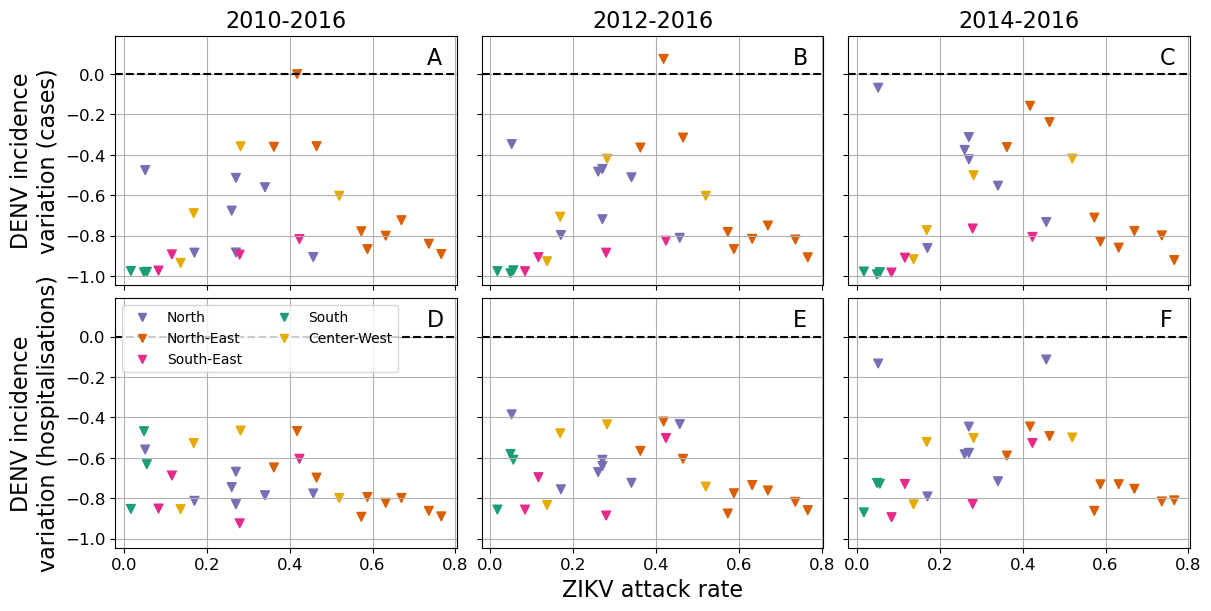

In [77]:
#== scatter hospitalisations

npre, npost = len( years_pre_combs ), 1

fig, ax = plt.subplots( figsize = ( 12, 6 ), nrows = 2, ncols = npre,
                      constrained_layout = True, sharex = True, sharey = True )

def get_label( years ):
    
    if len( years ) == 0:
        raise ValueError
    elif len( years ) == 1:
        return str( years[0] )
    else:
        return '{}-{}'.format( min( years ), max( years ) )

for i in range( npre ):

        # plot cases in first row
        axi = ax[0,i]
        axi.scatter( res['zikv_ar'], res['delta_inc_c_raw'][:,i,j], c = res['color'],
                   marker = 'v', s = 40 )
        axi.grid()
        axi.axhline( y = 0, c = 'black', ls = '--' )
    
        # plot cases in second row
        axi = ax[1,i]
        axi.scatter( res['zikv_ar'], res['delta_inc_h_raw'][:,i,j], c = res['color'],
                   marker = 'v', s = 40 )
        axi.grid()
        axi.axhline( y = 0, c = 'black', ls = '--' )


for i in range( npre ):
    ax[0,i].set_title( get_label( years_pre_combs[i] ), fontsize = 16 )
        

ax[0,0].set_ylabel( 'DENV incidence\nvariation (cases)', fontsize = 16 )
ax[1,0].set_ylabel( 'DENV incidence\nvariation (hospitalisations)', fontsize = 16 )

ax[1,1].set_xlabel( 'ZIKV attack rate', fontsize = 16 )

handles = [Line2D([0],[0],ls='',marker='v', color=color) for region, color in region2color.items()]
labels = [region for region, color in region2color.items()]

#ax[0,2].legend( handles = handles, labels = labels, bbox_to_anchor = ( 1.05, -0.5 ) )
ax[1,0].legend( handles = handles, labels = labels, ncols = 2, 
                loc = 'upper left', fontsize = 10 )


letters = 'ABCDEF'
for iax, axi in enumerate( ax.flatten() ):
    axi.tick_params( labelsize = 12 )
    axi.text( 0.73, 0.05, letters[iax], fontsize = 16 )
    axi.set_ylim( top = 0.19 )
    